In [1]:
import rebound  # will only work if rebound is installed in your python distro
import numpy as np  #  math stuff 
import matplotlib.pyplot as plt  # generic plotting stuff 
%matplotlib inline 


### Numerical problem for Problem set #5

### Exploring how a large mass particle settles into a star cluster and then wanders

In this problem, we will create a star cluster that described by  a Plummer model,  
https://en.wikipedia.org/wiki/Plummer_model .
We will explore what happens if a massive particle collides with the cluster and sinks into its center. 
A massive particle, like a black hole, would affect the density distribution of a star cluster or a galaxy bulge. 
Even after it has settled, the black hole would experience perturbations from gravitational encounters which cause it to wander. 
This behavior is called "Brownian motion". 

Choose one of the following settings to explore:

    a. Compare the radial density distribution of stars in the cluster before and after a heavy particle sinks into the center.  
You could run a simulation without the heavy particle and then compare it with a simulation that contains the heavy particle.
You could try changing the cluster core radius or the mass of the heavy particle. 

    b. Eventually the heavy particle remains near the center of the cluster.  However, the heavy particle would not necessarily be stationary, it would experience Brownian motion due to gravitational encounters.  How large are its excursions from the center of mass of the entire system?  
    
You can measure the variance of a distribution of the heavy particle's distance to the cluster center of mass measured at different times. You could compare the heavy particle's Brownian motion in two different simulations.  
The two simulations you compare could differ 
in the number of cluster particles or in the heavy particle's mass, or in the heavy particle's initial velocity or position prior or in the size of the initial cluster's core radius. 

Some notes:  For part a. If the initial velocity of the heavy particle is too large, it will escape the cluster rather than spiraling in.
It may take longer for the heavy particle to spiral in if it initially has angular momentum (the initial velocity has a tangential component).  For part b.  I found that the heavy particle's brownian motion seems to increase with time. I started with initial conditions for the massive particle near the center of the cluster.  I saw different wandering in different simulations. 

In [5]:
from scipy import interpolate   # needed so we can use interp1d in the Plummer initial conditions generating routine

def Plummer(N, r0, totmass, G, seed=None):
    """Generate the initial conditions for an isotropic Plummer model (BT eqs. 4.83 with n=5, 4.92, 2.44b).
    modified from the routine by J Bailin on this repository https://github.com/jbailinua/gravhopper
    Apparently rebound's python version lacks the plummer model initial condition generation code that is available in the c-version
        
    Parameters
    ----------
    N  :     (int) Number of particles
    r0 :     (float) Cluster scale radius
    totmass: (float) Total cluster mass
    G:       (float) gravitational constant 
    seed : None, or (int), 
            Seed to initialize random number generator so as to enable repeatable initial conditions
            
    Returns
    -------
    x,y,z,vx,vy,vz,mass each as 1d N length float arrays  
    """

    if (seed is None):
        from datetime import datetime
        seed = int(datetime.now().timestamp())  # if you want a randomly chosen set 

    rng = np.random.default_rng(seed) # random number generator in python

    # generate random coordinates and velocities. Uses the law of
    # transformation of probabilities.
    rad_xi = rng.uniform(0.0, 1.0, size=N) # uniform distribution 
    radius = r0 / np.sqrt(rad_xi**(-2./3) - 1)
    costheta = rng.uniform(-1.0, 1.0, size=N)
    phi = rng.uniform(0.0, 2.0*np.pi, size=N)
    sintheta = np.sqrt(1.0 - costheta**2)
    x = radius * sintheta * np.cos(phi) # particle positions!
    y = radius * sintheta * np.sin(phi)
    z = radius * costheta

    # we need to chose the velocity component numerically
    # from Aarseth+ 1974, we want to draw q from q^2 (1-q^2)^(7/2)
    # and then assign the magnitude of v to be
    # v = q sqrt(2) (1 + r^2/b^2)^(-1/4)
    qax = np.arange(0, 1.01, 0.01)
    q_prob = qax**2 * (1. - qax**2)**(3.5)
    q_cumprob = np.cumsum(q_prob) # cumulative probability
    q_cumprob /= q_cumprob[-1]    # normalized correctly to end up at 1
    probtransform = interpolate.interp1d(q_cumprob, qax)   # reverse interpolation  # needs scipy.interpolate.interp1d 
    # now get the uniform random deviate and transform it
    vel_xi = rng.uniform(0.0, 1.0, size=N)
    q = probtransform(vel_xi)
    velocity = q * np.sqrt(2. * G * totmass / r0) * (1. + (radius/r0)**2)**(-0.25)
    cosveltheta = rng.uniform(-1.0, 1.0, size=N)
    velphi = rng.uniform(0.0, 2.0*np.pi, size=N)
    sinveltheta = np.sqrt(1.0 - cosveltheta**2)
    vx = velocity * sinveltheta * np.cos(velphi) # particle velocities!
    vy = velocity * sinveltheta * np.sin(velphi)
    vz = velocity * cosveltheta

    mass = np.ones((N)) * (totmass/N) # particle masses
    # return arrays
    return x,y,z,vx,vy,vz,mass 
    

# return a list of x,y positions and radii from cluster center as a function of time 
def getxyr(sim):
    xarr = np.zeros(sim.N)
    yarr = np.zeros(sim.N)
    rarr = np.zeros(sim.N)
    for i in range(sim.N):
        xarr[i] = sim.particles[i].x
        yarr[i] = sim.particles[i].y
        r2 = sim.particles[i].x*sim.particles[i].x + sim.particles[i].y*sim.particles[i].y \
            + sim.particles[i].z*sim.particles[i].z
        rarr[i] = np.sqrt(r2)
    return xarr,yarr,rarr


In [7]:
# set up a simulation with 
# arguments:
#   N: number of cluster particles, 
#   M_cluster: total mass of cluster 
#   R_cluster: radius of cluster 
#    --- G = 1 set 
# returns:
#   sim:  the rebound simulation
#   r0:   characteristic length scale 
#   t0:   relaxation time 
#   v0:   a characteristic velocity scale 

def create_sim(N,M_cluster,R_cluster):
    sim = rebound.Simulation() # create rebound simulation !
    sim.G = 1.0

    #M_cluster = 1             # total mass of the cluster
    #R_cluster = 1;            # Radius of the cluster
    #N = 200 # number of particles 
    E_cluster = 3./64.*np.pi*M_cluster*M_cluster/R_cluster;   # Energy of the cluster
    r0 = 16./(3.*np.pi)*R_cluster;   # Characteristic length scale
    t0 = sim.G*np.power(M_cluster,5./2.)*np.power(4.*E_cluster,-3./2.)*N/np.log(0.4*N); # Relaxation time
    print("Characteristic size:  \n", r0);
    print("Characteristic time (relaxation): \n", t0);
    print("particle mass:  \n", M_cluster/N);
    v0=np.sqrt(sim.G*M_cluster/r0)
    print("Characteristic velocity: \n",v0)

    sim.integrator    = 'LEAPFROG';   # to find list of possible integrators ?sim.integrator
    sim.dt            = 2e-5*t0;     # timestep
    sim.softening     = 0.01*r0;    # Softening parameter

    boxsize = 20.0*R_cluster  # viewing 
    sim.configure_box(boxsize)
    # sim.boundary = "none"  # by default no boundary 

    # Create a bunch of particles consistent with a Plummer model with N particles 
    x,y,z,vx,vy,vz,mass  = Plummer(N, r0, M_cluster, sim.G,seed=None)
    # add these particles to the simulation 
    for i in range(N):
        sim.add(m=mass[i],x=x[i],y=y[i],z=z[i],vx=vx[i],vy=vy[i],vz=vz[i])

    sim.move_to_com()  # move to center of mass 
    return sim,r0,t0,v0

In [9]:
# display the simulation xy positions and radial distribution
# if mm = 1 then show the extra massive particle in read,  otherwise don't
def show_sim(sim,mm):
    xarr,yarr,rarr = getxyr(sim)
    fig,axarr = plt.subplots(1,2,figsize=(5,2))
    axarr[0].plot(xarr,yarr,'.',ms=1)
    if (mm==1):
        axarr[0].plot(xarr[-1],yarr[-1],'ro')  # plot massive particle!
    axarr[0].set_aspect('equal')
    boxsize = sim.boxsize.x 
    axarr[0].set_ylim(-boxsize,boxsize)
    axarr[0].set_xlim(-boxsize,boxsize)
    jj = axarr[1].hist(rarr,bins=30,range=[0,20])
    axarr[1].set_xlabel('r')

In [11]:
M_cluster = 1; R_cluster = 1; N=300
sim_a,r0,t0,v0 = create_sim(N,M_cluster,R_cluster)  # create a simulation with a cluster in it

# add a heavy mass 
mbig = M_cluster/10. # it's big!
sim_a.add(m=mbig,x = 3*r0, y=0,z=0, vx=-v0,vy=0,vz=0) # chosing radial orbit 
sim_a.move_to_com()  # move to center of mass frame 

Characteristic size:  
 1.6976527263135504
Characteristic time (relaxation): 
 138.6074263486668
particle mass:  
 0.0033333333333333335
Characteristic velocity: 
 0.7674950309598664


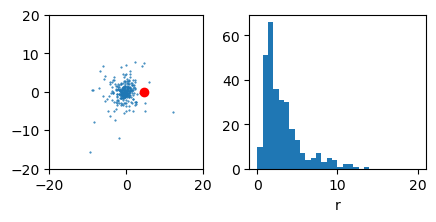

In [13]:
show_sim(sim_a,1) # integrate to t=1, show the simulation and the radial distribution 
xarr_a_0,yarr_a_0,rarr_a_0 = getxyr(sim_a) # 
# store some arrays

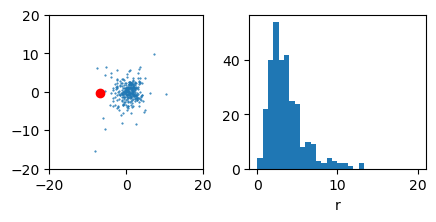

In [15]:
sim_a.integrate(20)
show_sim(sim_a,1)
xarr_a_20,yarr_a_20,rarr_a_20 = getxyr(sim_a)

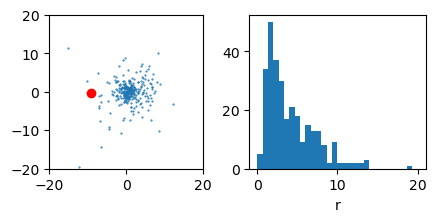

In [17]:
sim_a.integrate(40)
show_sim(sim_a,1)
xarr_a_40,yarr_a_40,rarr_a_40 = getxyr(sim_a)

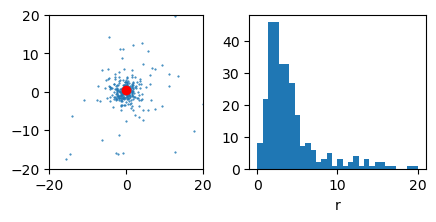

In [19]:
sim_a.integrate(100)
show_sim(sim_a,1)
xarr_a_100,yarr_a_100,rarr_a_100 = getxyr(sim_a) # store information!
sim_a.integrate(200)
xarr_a_200,yarr_a_200,rarr_a_200 = getxyr(sim_a)

In [21]:
#M_cluster = 1; R_cluster = 1
sim_b,r0,t0,v0 = create_sim(N,M_cluster,R_cluster)  
# create a simulation with a cluster in it and no extra mass 

# don't add another large mass 
#mbig = M_cluster/10. # it's big!
#sim_a.add(m=mbig,x = 3*r0, y=0,z=0, vx=-v0,vy=0,vz=0)
sim_b.move_to_com()  # move to center of mass frame 

Characteristic size:  
 1.6976527263135504
Characteristic time (relaxation): 
 138.6074263486668
particle mass:  
 0.0033333333333333335
Characteristic velocity: 
 0.7674950309598664


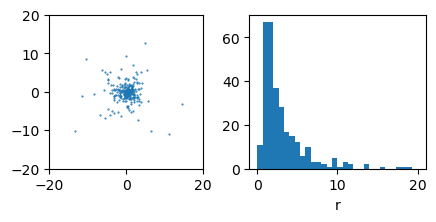

In [23]:
sim_b.integrate(100)
show_sim(sim_b,0)
xarr_b_100,yarr_b_100,rarr_b_100 = getxyr(sim_b)
sim_b.integrate(200)
xarr_b_200,yarr_b_200,rarr_b_200 = getxyr(sim_b)

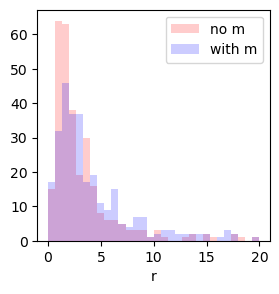

In [26]:
# compare the two simulations!
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.hist(rarr_b_100,bins=30,range=[0,20],alpha=0.2,color='red',label='no m') # no extra mass
ax.hist(rarr_a_100,bins=30,range=[0,20],alpha=0.2,color='blue', label='with m') # with extra mass 
ax.set_xlabel('r')
ax.legend()

### cluster spreads out due to infall of large mass 

### part b exploration 

In [43]:
# store distance (in x) of last particle from the center of mass as a function of time 
# by integrating the simulation sim to times given in the array tlin
# return the list of x values for this particle
def int_bigmass(sim,tlin):
    xbig_arr = tlin*0
    for i in range(len(tlin)):
        sim.integrate(tlin[i])
        sim.move_to_com()   # make sure in center of mass frame all the time!
        plast = sim.particles[sim.N-1]
        #r = np.sqrt(plast.x**2 + plast.y**2 + plast.z**2)
        xbig_arr[i] = plast.x  # only using x 
    return xbig_arr


In [45]:
M_cluster = 1; R_cluster = 1; N=300
simm_a,r0,t0,v0 = create_sim(N,M_cluster,R_cluster)  # create a simulation with a cluster in it

# add another large mass 
mbig = M_cluster/10. # it's big!
simm_a.add(m=mbig,x = 0.1*r0, y=0,z=0, vx=0,vy=0,vz=0) # start it close to origin
simm_a.move_to_com()  # move to center of mass frame 

Characteristic size:  
 1.6976527263135504
Characteristic time (relaxation): 
 138.6074263486668
particle mass:  
 0.0033333333333333335
Characteristic velocity: 
 0.7674950309598664


In [47]:
tlin = np.linspace(2,300,150)
xbig_a = int_bigmass(simm_a,tlin)


Text(0.5, 0, 'time')

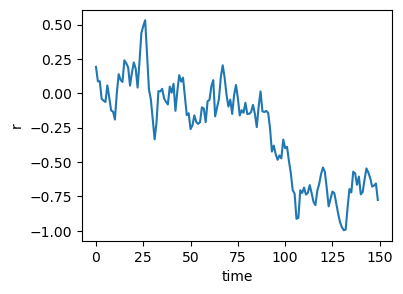

In [49]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(xbig_a) # show brownian motion!
ax.set_ylabel('r')
ax.set_xlabel('time')
# plot brownian motion!